In [34]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [35]:
def wrangle(csv_file):

    #read file
    df = pd.read_csv(csv_file)

    
    #leaky columns
    cols_to_drop = []

    #recast target
    df['Transported'] = df['Transported'].astype(int)

        
    #high cardinality features   
    cols_to_drop.extend(['PassengerId', 'Name', 'Cabin'])
      

    #drop columns
    df.drop(columns=cols_to_drop, inplace=True)
    df.dropna(inplace=True)

    return df

In [36]:
#read csv and check first rows
df = wrangle('train.csv')
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [37]:
#get information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6923 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    6923 non-null   object 
 1   CryoSleep     6923 non-null   object 
 2   Destination   6923 non-null   object 
 3   Age           6923 non-null   float64
 4   VIP           6923 non-null   object 
 5   RoomService   6923 non-null   float64
 6   FoodCourt     6923 non-null   float64
 7   ShoppingMall  6923 non-null   float64
 8   Spa           6923 non-null   float64
 9   VRDeck        6923 non-null   float64
 10  Transported   6923 non-null   int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 649.0+ KB


In [38]:
cat = df.select_dtypes('object').columns

print(df[cat].nunique())
print("*****************")

HomePlanet     3
CryoSleep      2
Destination    3
VIP            2
dtype: int64
*****************


In [39]:
df['Transported'].astype(int).head()

0    0
1    1
2    0
3    0
4    1
Name: Transported, dtype: int64

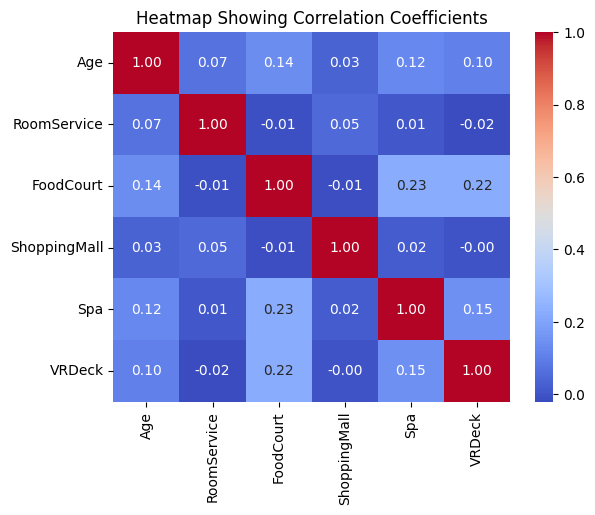

In [40]:
#get correlation of numerical features
num_corr = df.select_dtypes('float').corr()
sns.heatmap(num_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Showing Correlation Coefficients');


In [41]:
#describe
num_feat = df.select_dtypes('float').describe()
num_feat

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000
mean,28.891665,226.079590,480.432760,179.328037,318.185035,303.768309
std,14.514540,673.908258,1672.766209,633.614987,1159.247480,1125.448364
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,81.500000,29.000000,65.500000,51.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,20336.000000


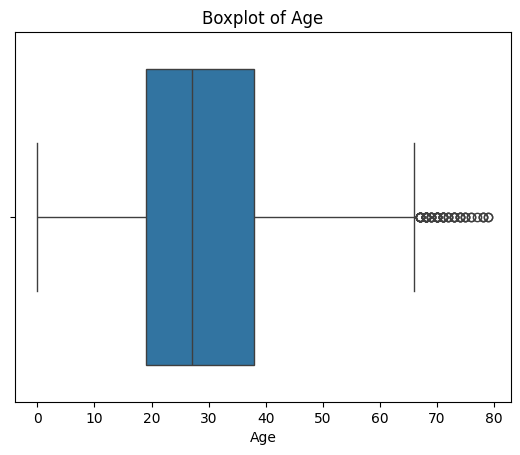

888888888888888


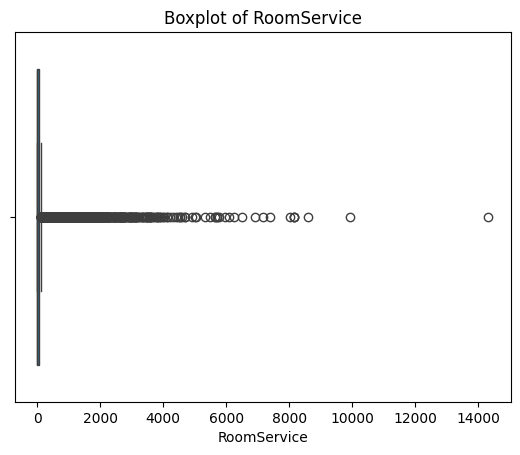

888888888888888


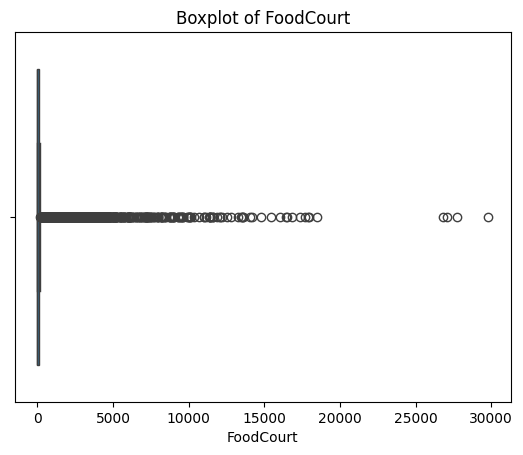

888888888888888


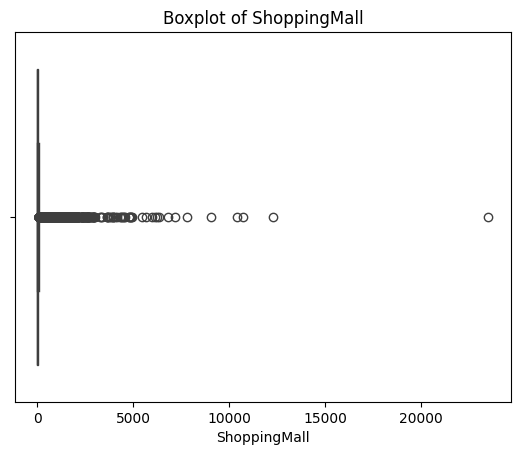

888888888888888


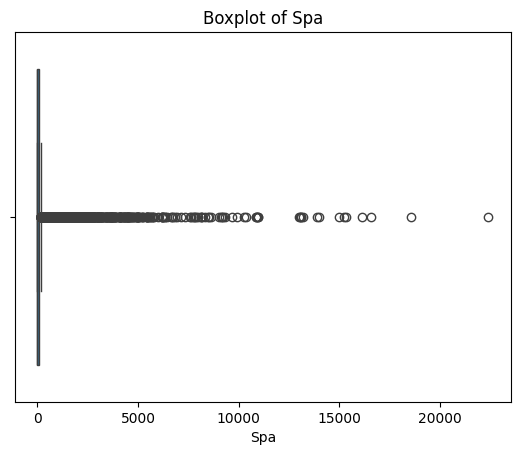

888888888888888


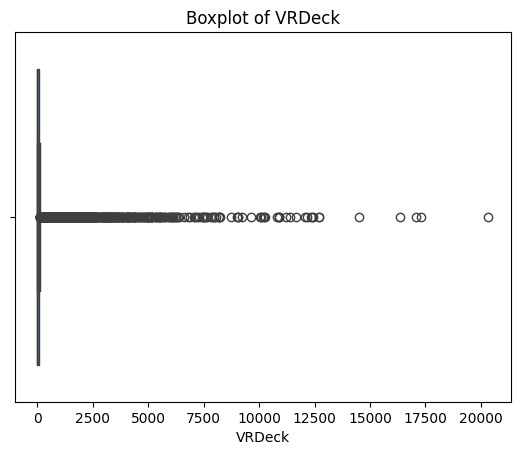

888888888888888


In [42]:
#plot boxplots
for col in num_feat.columns:
    col_plot = df[col]
    sns.boxplot(col_plot, orient='h')
    plt.title(f'Boxplot of {col}')
    plt.show()
    print('888888888888888')

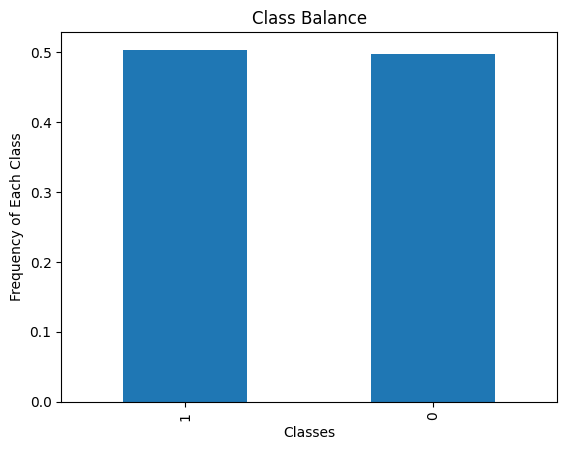

In [43]:
#check class balance
df['Transported'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Frequency of Each Class')
plt.title('Class Balance');

In [44]:
#get features and target
target = 'Transported'
X = df.drop(columns=target)
y = df[target]
print('DF Shape', df.shape)
print('X shape',X.shape)
print('Y', y.shape)

DF Shape (6923, 11)
X shape (6923, 10)
Y (6923,)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)


X_train (5538, 10)
X_test (1385, 10)
y_train (5538,)
y_test (1385,)


In [46]:
cat_feat = X.select_dtypes('float').columns
num_feat = X.select_dtypes('float').columns


In [47]:
baseline_score = y.value_counts(normalize=True).max()
print('Baseline accuracy:', baseline_score)


Baseline accuracy: 0.5031055900621118


In [48]:
#compare scores
model_names = []
final_train_acc = []
final_test_acc = []
final_cv = []

In [68]:
preprocessor = ColumnTransformer([
    ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), cat_feat),
    ('num', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), num_feat)
])

In [50]:
#make pipeline
model_log = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000)
)

#model name from pipeline
model_log_name = model_log.steps[-1][0]
model_names.append(model_log_name)

#fit model
model_log.fit(X_train, y_train)

#train model
y_pred_train_log = model_log.predict(X_train)

#train accuracy
acc_train_log = accuracy_score(y_train, y_pred_train_log)
final_train_acc.append(acc_train_log)

#predict on test set
y_pred_test_log = model_log.predict(X_test)

#test accuracy
acc_test_log = accuracy_score(y_test, y_pred_test_log)
final_test_acc.append(acc_test_log)

#cross validation
cv_scores_log = cross_val_score(model_log, X, y, cv=5, scoring='accuracy')
final_cv.append(round(cv_scores_log.mean(),2))

In [51]:
from sklearn.neighbors import KNeighborsClassifier


# Create a pipeline with KNN instead of Logistic Regression
model_knn = make_pipeline(
    preprocessor,
    KNeighborsClassifier(n_neighbors=5)  # You can change n_neighbors as needed
)

# Model name from pipeline
model_knn_name = model_knn.steps[-1][0]
model_names.append(model_knn_name)

# Fit model
model_knn.fit(X_train, y_train)

# Predict on train set
y_pred_train_knn = model_knn.predict(X_train)

# Train accuracy
acc_train_knn = accuracy_score(y_train, y_pred_train_knn)
final_train_acc.append(acc_train_knn)

# Predict on test set
y_pred_test_knn = model_knn.predict(X_test)

# Test accuracy
acc_test_knn = accuracy_score(y_test, y_pred_test_knn)
final_test_acc.append(acc_test_knn)
print(acc_test_knn)
# Cross-validation
cv_scores_knn = cross_val_score(model_knn, X, y, cv=5, scoring='accuracy')
final_cv.append(round(cv_scores_knn.mean(), 2))
print(cv_scores_knn.mean())

0.7054151624548737
0.6988301579683228


In [52]:
#make pipeline for decision tree
model_tr = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth= 5, random_state=42)
)

#model name from pipeline
model_tr_name = model_tr.steps[-1][0]
model_names.append(model_tr_name)

#fit model
model_tr.fit(X_train, y_train)

#train model
y_pred_train_tr = model_tr.predict(X_train)

#train accuracy
acc_train_tr = accuracy_score(y_train, y_pred_train_tr)
final_train_acc.append(acc_train_tr)

#predict on test set
y_pred_test_tr = model_tr.predict(X_test)

#test accuracy
acc_test_tr = accuracy_score(y_test, y_pred_test_tr)
final_test_acc.append(acc_test_tr)

#cross validation
cv_scores_tr = cross_val_score(model_tr, X, y, cv=5, scoring='accuracy')
final_cv.append(round(cv_scores_tr.mean(),2))

In [53]:
#tree depth
depth = model_tr.named_steps['decisiontreeclassifier'].get_depth()
depth

5

In [54]:

#store acc scores
depths = []
training_accuracy = []
test_accuracy = []
gaps = []

#tune model
params = range(1, 101, 2)
for d in params:
    depths.append(d)
    model_tr = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth= d, random_state=42)
    )

    #fit model
    model_tr.fit(X_train, y_train)

    #train model
    y_pred_train = model_tr.predict(X_train)

    #train accuracy
    acc_train = accuracy_score(y_train, y_pred_train)

    #append training score
    training_accuracy.append(acc_train)

    #predict on test set
    y_pred_test = model_tr.predict(X_test)

    #test accuracy
    acc_test = accuracy_score(y_test, y_pred_test)

    #append test scores
    test_accuracy.append(acc_test)

    #gap
    gap = (acc_train - acc_test)
    gaps.append(gap)



In [55]:
#store accuracy scores in df
accuracy_df = pd.DataFrame({
    'depths': depths,
    'train_acc': training_accuracy,
    'test_acc': test_accuracy,
    'gap': gaps
})
accuracy_df.head(10)

,depths,train_acc,test_acc,gap
0,1,0.668292,0.674368,-0.006076
1,3,0.776273,0.776173,0.000100
2,5,0.793788,0.792058,0.001731
3,7,0.815457,0.790614,0.024843
4,9,0.837486,0.793502,0.043985
5,11,0.853557,0.786282,0.067276
6,13,0.867642,0.775451,0.092190
7,15,0.878476,0.783394,0.095082
8,17,0.886963,0.779783,0.107179
9,19,0.892019,0.781227,0.110791


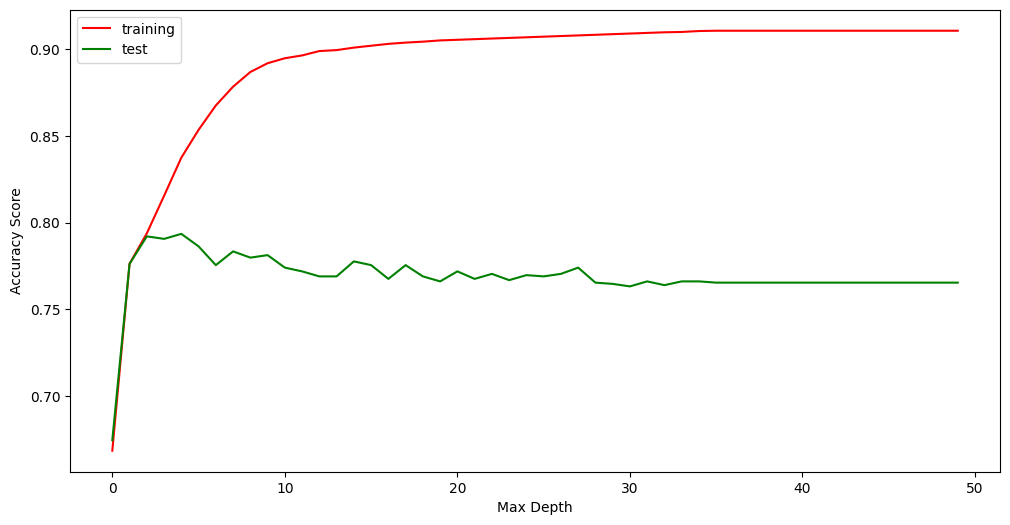

In [56]:
#plot accuracies
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(training_accuracy, color='red', label='training')
ax.plot(test_accuracy, color='green', label='test')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Accuracy Score')
ax.legend()
plt.show();

In [57]:

#make pipeline random forest
model_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(max_depth=60, n_estimators=100, random_state=42)
)

#model name from pipeline
model_rf_name = model_rf.steps[-1][0]
model_names.append(model_rf_name)


#fit model
model_rf.fit(X_train, y_train)


#train model
y_pred_train_rf = model_rf.predict(X_train)


#train accuracy
acc_train_rf = accuracy_score(y_train, y_pred_train_rf)
final_train_acc.append(acc_train_rf)


#predict on test set
y_pred_test_rf = model_rf.predict(X_test)


#test accuracy
acc_test_rf = accuracy_score(y_test, y_pred_test_rf)
final_test_acc.append(acc_test_rf)


#cross validation
cv_scores_rf = cross_val_score(model_rf, X, y, cv=5, scoring='accuracy')
final_cv.append(round(cv_scores_rf.mean(),2))

In [58]:
dept = [estimator.get_depth() for estimator in model_rf['randomforestclassifier'].estimators_]
max_dept = max(dept) 
ave_dept = sum(dept)/len(dept) 
print('Max depth:', max_dept)
print('Average depth:', ave_dept)

Max depth: 60
Average depth: 60.0


In [69]:
# Gradient Boosting pipeline
model_gb = make_pipeline(
    preprocessor,
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
)

# model name
model_gb_name = model_gb.steps[-1][0]
model_names.append(model_gb_name)

# fit model
model_gb.fit(X_train, y_train)

# train prediction
y_pred_train_gb = model_gb.predict(X_train)
acc_train_gb = accuracy_score(y_train, y_pred_train_gb)
final_train_acc.append(acc_train_gb)


# test prediction
y_pred_test_gb = model_gb.predict(X_test)
acc_test_gb = accuracy_score(y_test, y_pred_test_gb)
final_test_acc.append(acc_test_gb)

# cross-validation
cv_scores_gb = cross_val_score(model_gb, X, y, cv=5, scoring='accuracy')
final_cv.append(round(cv_scores_gb.mean(), 2))

In [60]:
'''from sklearn.model_selection import GridSearchCV

# Pipeline
model_gb = make_pipeline(
    preprocessor,
    #GradientBoostingClassifier(random_state=42)
)

# Hyperparameter grid
param_grid = {
    'gradientboostingclassifier__n_estimators': [100, 150, 200],
    'gradientboostingclassifier__learning_rate': [0.01, 0.05, 0.1],
    'gradientboostingclassifier__max_depth': [3, 4, 5],
    'gradientboostingclassifier__subsample': [0.8, 1.0]
}

# Grid search
grid_search = GridSearchCV(
    model_gb,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
grid_search.fit(X_train, y_train)

# Best estimator
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", round(grid_search.best_score_, 3))
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

acc_train_best = accuracy_score(y_train, y_train_pred)
acc_test_best = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", round(acc_train_best, 3))
print("Test Accuracy:", round(acc_test_best, 3))'''

'from sklearn.model_selection import GridSearchCV\n\n# Pipeline\nmodel_gb = make_pipeline(\n    preprocessor,\n    #GradientBoostingClassifier(random_state=42)\n)\n\n# Hyperparameter grid\nparam_grid = {\n    \'gradientboostingclassifier__n_estimators\': [100, 150, 200],\n    \'gradientboostingclassifier__learning_rate\': [0.01, 0.05, 0.1],\n    \'gradientboostingclassifier__max_depth\': [3, 4, 5],\n    \'gradientboostingclassifier__subsample\': [0.8, 1.0]\n}\n\n# Grid search\ngrid_search = GridSearchCV(\n    model_gb,\n    param_grid,\n    cv=5,\n    scoring=\'accuracy\',\n    n_jobs=-1,\n    verbose=1\n)\n\n# Fit\ngrid_search.fit(X_train, y_train)\n\n# Best estimator\nbest_model = grid_search.best_estimator_\nprint("Best Parameters:", grid_search.best_params_)\nprint("Best CV Accuracy:", round(grid_search.best_score_, 3))\ny_train_pred = best_model.predict(X_train)\ny_test_pred = best_model.predict(X_test)\n\nacc_train_best = accuracy_score(y_train, y_train_pred)\nacc_test_best = acc

In [70]:
#compare scores in dataframe

df_scores = pd.DataFrame({
    'model_name': model_names,
    'train accuracy':final_train_acc,
    'test accuracy': final_test_acc,
    'cv score': final_cv
})
df_scores.head()

,model_name,train accuracy,test accuracy,cv score
0,logisticregression,0.856085,0.786282,0.78
1,kneighborsclassifier,0.760563,0.705415,0.70
2,decisiontreeclassifier,0.793788,0.792058,0.78
3,randomforestclassifier,0.884254,0.768953,0.77
4,gradientboostingclassifier,0.809137,0.800722,0.79


In [71]:
def wrangle_test(csv_file):

    #read file
    df = pd.read_csv(csv_file)
    
    #leaky columns
    cols_to_drop = []

    #recast target
    #df['Transported'] = df['Transported'].astype(int)

    #identify multicollinearity
    passenger_ids = df['PassengerId'].copy()
    
    #high cardinality features   
    cols_to_drop.extend(['PassengerId', 'Name', 'Cabin'])
    
    

    #drop columns
    df.drop(columns=cols_to_drop, inplace=True)

    return df, passenger_ids 

In [72]:
#get test data
test, passenger_ids = wrangle_test('test.csv')



In [73]:
print(model_gb)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                               

In [74]:
test_pred_gb = model_gb.predict(test)

#

In [75]:
#submission
submission_gb = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': test_pred_gb.astype(bool)  # Ensure boolean output
})

submission_gb.to_csv('submission_gb.csv', index=False)

In [76]:
submission_gb.shape

(4277, 2)